**Model Design and Implementation**

In [1]:
from keras.datasets import boston_housing

(train_data, train_targets), (test_data, test_targets) =  boston_housing.load_data()

57026/57026 ━━━━━━━━━━━━━━━━━━━━ 0s 1us/step


In [2]:
train_data.shape

(404, 13)

In [3]:
test_data.shape

(102, 13)

In [4]:
train_targets

array([15.2, 42.3, 50. , 21.1, 17.7, 18.5, 11.3, 15.6, 15.6, 14.4, 12.1,
       17.9, 23.1, 19.9, 15.7,  8.8, 50. , 22.5, 24.1, 27.5, 10.9, 30.8,
       32.9, 24. , 18.5, 13.3, 22.9, 34.7, 16.6, 17.5, 22.3, 16.1, 14.9,
       23.1, 34.9, 25. , 13.9, 13.1, 20.4, 20. , 15.2, 24.7, 22.2, 16.7,
       12.7, 15.6, 18.4, 21. , 30.1, 15.1, 18.7,  9.6, 31.5, 24.8, 19.1,
       22. , 14.5, 11. , 32. , 29.4, 20.3, 24.4, 14.6, 19.5, 14.1, 14.3,
       15.6, 10.5,  6.3, 19.3, 19.3, 13.4, 36.4, 17.8, 13.5, 16.5,  8.3,
       14.3, 16. , 13.4, 28.6, 43.5, 20.2, 22. , 23. , 20.7, 12.5, 48.5,
       14.6, 13.4, 23.7, 50. , 21.7, 39.8, 38.7, 22.2, 34.9, 22.5, 31.1,
       28.7, 46. , 41.7, 21. , 26.6, 15. , 24.4, 13.3, 21.2, 11.7, 21.7,
       19.4, 50. , 22.8, 19.7, 24.7, 36.2, 14.2, 18.9, 18.3, 20.6, 24.6,
       18.2,  8.7, 44. , 10.4, 13.2, 21.2, 37. , 30.7, 22.9, 20. , 19.3,
       31.7, 32. , 23.1, 18.8, 10.9, 50. , 19.6,  5. , 14.4, 19.8, 13.8,
       19.6, 23.9, 24.5, 25. , 19.9, 17.2, 24.6, 13

In [5]:
mean= train_data.mean(axis=0)
train_data -= mean
std= train_data.std(axis=0)
train_data /=std
test_data -=mean
test_data /=std

In [6]:
from keras import models
from keras import layers
def build_model():
    model=models.Sequential()
    model.add(layers.Dense(64, activation='relu',
                          input_shape=(train_data.shape[1],)))
    model.add(layers.Dense(64, activation='relu'))
    model.add(layers.Dense(1))
    model.compile(optimizer='rmsprop', loss='mse', metrics=['mae'])
    return model

In [7]:
import numpy as np
k = 4
num_val_samples = len(train_data) // k
num_epochs = 100
all_scores = []
for i in range(k):
    print('processing fold #', i)
    # Prepare the validation data: data from partition # k
    val_data = train_data[i * num_val_samples: (i + 1) * num_val_samples]
    val_targets = train_targets[i * num_val_samples: (i + 1) * num_val_samples]
# Prepare the training data: data from all other partitions
    partial_train_data = np.concatenate(
        [train_data[:i * num_val_samples],
         train_data[(i + 1) * num_val_samples:]],
        axis=0)
    partial_train_targets = np.concatenate(
        [train_targets[:i * num_val_samples],
         train_targets[(i + 1) * num_val_samples:]],
        axis=0)

    # Build the Keras model (already compiled)
    model = build_model()
    # Train the model (in silent mode, verbose=0)
    model.fit(partial_train_data, partial_train_targets,
              epochs=num_epochs, batch_size=1, verbose=0)
    # Evaluate the model on the validation data
    val_mse, val_mae = model.evaluate(val_data, val_targets, verbose=0)
    all_scores.append(val_mae)

processing fold # 0


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


processing fold # 1
processing fold # 2
processing fold # 3


In [8]:
all_scores

[2.1236302852630615, 2.7553470134735107, 2.7073891162872314, 2.46787428855896]

In [9]:

np.mean(all_scores)


2.513560175895691

In [10]:
from keras import backend as K

# Some memory clean-up
K.clear_session()

In [12]:
num_epochs = 500
all_mae_histories = []
for i in range(k):
    print('processing fold #', i)
    # Prepare the validation data: data from partition # k
    val_data = train_data[i * num_val_samples: (i + 1) * num_val_samples]
    val_targets = train_targets[i * num_val_samples: (i + 1) * num_val_samples]

    # Prepare the training data: data from all other partitions
    partial_train_data = np.concatenate(
        [train_data[:i * num_val_samples],
         train_data[(i + 1) * num_val_samples:]],
        axis=0)
    partial_train_targets = np.concatenate(
        [train_targets[:i * num_val_samples],
         train_targets[(i + 1) * num_val_samples:]],
        axis=0)

    # Build the Keras model (already compiled)
    model = build_model()
    # Train the model (in silent mode, verbose=0)
    history = model.fit(partial_train_data, partial_train_targets,
                        validation_data=(val_data, val_targets),
                        epochs=num_epochs, batch_size=1, verbose=0)
    mae_history = history.history['val_mae']
    all_mae_histories.append(mae_history)

processing fold # 0
processing fold # 1
processing fold # 2
processing fold # 3


In [13]:
average_mae_history = [
    np.mean([x[i] for x in all_mae_histories]) for i in range(num_epochs)]

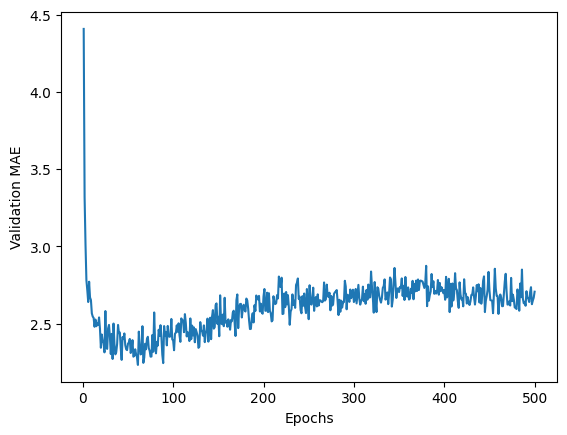

In [14]:
import matplotlib.pyplot as plt

plt.plot(range(1, len(average_mae_history) + 1), average_mae_history)
plt.xlabel('Epochs')
plt.ylabel('Validation MAE')
plt.show()

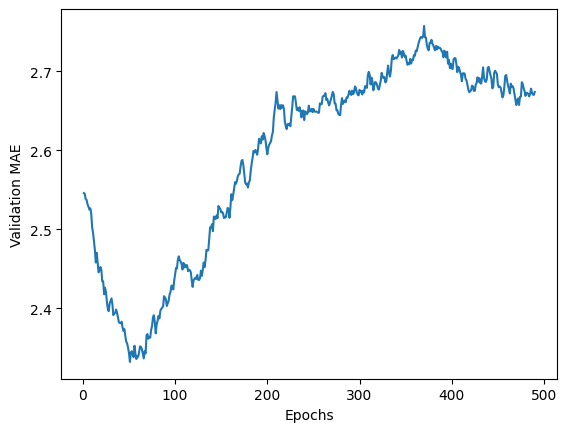

In [15]:
def smooth_curve(points, factor=0.9):
  smoothed_points = []
  for point in points:
    if smoothed_points:
      previous = smoothed_points[-1]
      smoothed_points.append(previous * factor + point * (1 - factor))
    else:
      smoothed_points.append(point)
  return smoothed_points

smooth_mae_history = smooth_curve(average_mae_history[10:])

plt.plot(range(1, len(smooth_mae_history) + 1), smooth_mae_history)
plt.xlabel('Epochs')
plt.ylabel('Validation MAE')
plt.show()

In [16]:
# Get a fresh, compiled model.
model = build_model()
# Train it on the entirety of the data.
model.fit(train_data, train_targets,
          epochs=80, batch_size=16, verbose=0)
test_mse_score, test_mae_score = model.evaluate(test_data, test_targets)

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 12.0297 - mae: 2.3230 


In [17]:
test_mae_score

2.4905009269714355

**Hyperparameter Tuning**

Training with batch_size=16, epochs=50, optimizer=adam


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Training with batch_size=16, epochs=50, optimizer=rmsprop
Training with batch_size=16, epochs=50, optimizer=sgd
Training with batch_size=16, epochs=100, optimizer=adam
Training with batch_size=16, epochs=100, optimizer=rmsprop
Training with batch_size=16, epochs=100, optimizer=sgd
Training with batch_size=16, epochs=200, optimizer=adam
Training with batch_size=16, epochs=200, optimizer=rmsprop
Training with batch_size=16, epochs=200, optimizer=sgd
Training with batch_size=32, epochs=50, optimizer=adam
Training with batch_size=32, epochs=50, optimizer=rmsprop
Training with batch_size=32, epochs=50, optimizer=sgd
Training with batch_size=32, epochs=100, optimizer=adam
Training with batch_size=32, epochs=100, optimizer=rmsprop
Training with batch_size=32, epochs=100, optimizer=sgd
Training with batch_size=32, epochs=200, optimizer=adam
Training with batch_size=32, epochs=200, optimizer=rmsprop
Training with batch_size=32, epochs=200, optimizer=sgd
Training with batch_size=64, epochs=50, o

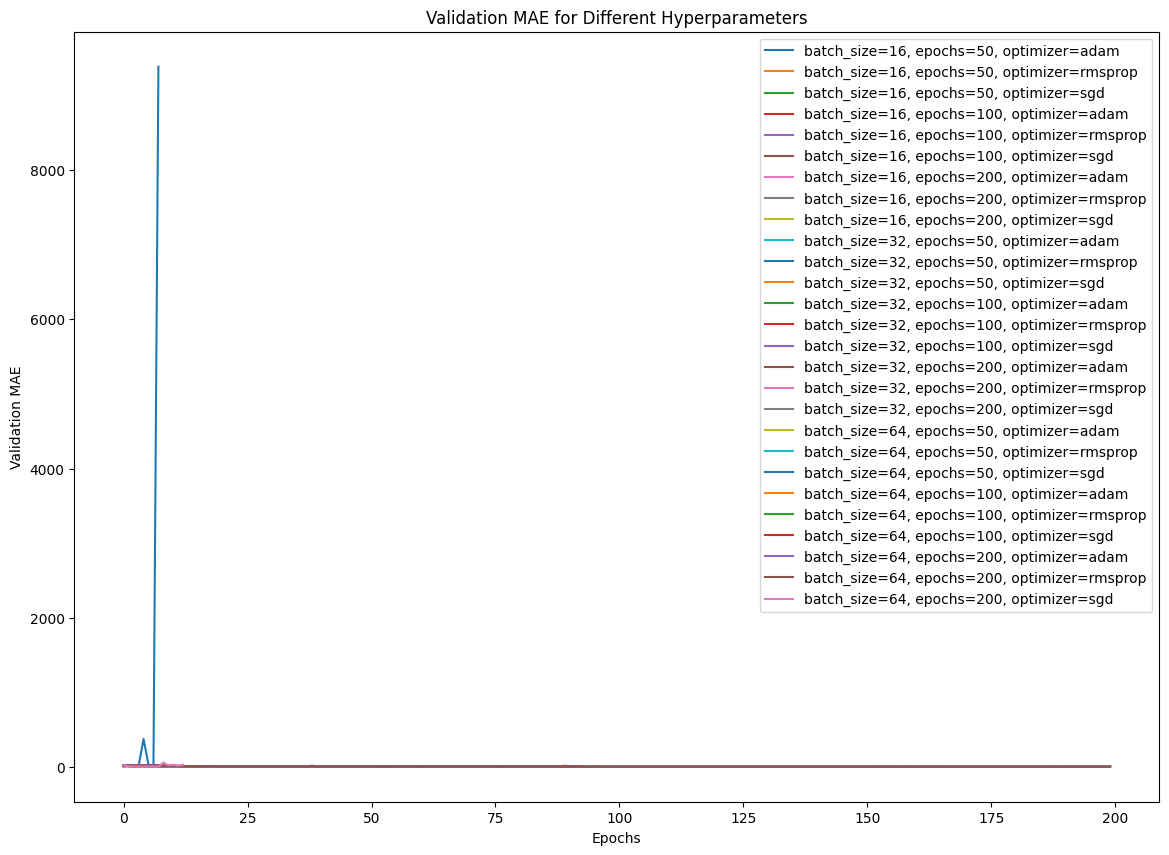

In [34]:
import numpy as np
from keras import models, layers
from keras.optimizers import Adam, RMSprop, SGD
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from keras.datasets import boston_housing

# Load and normalize the data
(train_data, train_targets), (test_data, test_targets) = boston_housing.load_data()
scaler = StandardScaler()
train_data = scaler.fit_transform(train_data)
test_data = scaler.transform(test_data)

# Function to build the model
def build_model(optimizer='adam'):
    model = models.Sequential()
    model.add(layers.Dense(64, activation='relu', input_shape=(train_data.shape[1],)))
    model.add(layers.Dense(64, activation='relu'))
    model.add(layers.Dense(1))  # Output layer for regression
    model.compile(optimizer=optimizer, loss='mse', metrics=['mae'])
    return model

# Hyperparameters to tune
batch_sizes = [16, 32, 64]
epochs_list = [50, 100, 200]
optimizers = ['adam', 'rmsprop', 'sgd']

# To store results
results = {}

for batch_size in batch_sizes:
    for epochs in epochs_list:
        for optimizer_name in optimizers:
            print(f"Training with batch_size={batch_size}, epochs={epochs}, optimizer={optimizer_name}")

            # Build model with the current optimizer
            optimizer = None
            if optimizer_name == 'adam':
                optimizer = Adam()
            elif optimizer_name == 'rmsprop':
                optimizer = RMSprop()
            elif optimizer_name == 'sgd':
                optimizer = SGD()

            model = build_model(optimizer)

            # Train the model
            history = model.fit(train_data, train_targets, validation_split=0.2,
                                epochs=epochs, batch_size=batch_size, verbose=0)

            # Store validation metrics
            val_mae = history.history['val_mae']
            val_loss = history.history['val_loss']

            # Save the results for analysis
            key = f"batch_size={batch_size}, epochs={epochs}, optimizer={optimizer_name}"
            results[key] = {
                'val_mae': val_mae,
                'val_loss': val_loss
            }

# Plotting the results
plt.figure(figsize=(14, 10))

for key in results.keys():
    plt.plot(results[key]['val_mae'], label=key)

plt.xlabel('Epochs')
plt.ylabel('Validation MAE')
plt.title('Validation MAE for Different Hyperparameters')
plt.legend()
plt.show()
